## 1. How calculate number of clusters

As we have unsupervised method, we do not have benchmark with which we can compare our results. But after we got clusters, we can calculate SSE:

In [9]:
k = 3
n_samples = 1000
x, y = make_blobs(n_samples=n_samples, random_state=random_state)
km = KMeans(n_clusters=k, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=random_state) 
y_pred = km.fit_predict(x)

print(f'SSE: {km.inertia_}')

SSE: 1685.7317234035831


### 1.1 Elbow method

To calculate real number of clusters, we can use elbow method. We take different values of the number of clusters, then we calculate for each number of clusters SSE and build graph:

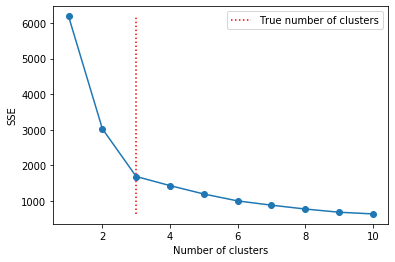

In [10]:
SSE = []

for k in list(range(1,11)):
    km = KMeans(n_clusters=k, n_init=10, max_iter=300, tol=1e-04, random_state=random_state)
    km.fit(x)
    SSE.append(km.inertia_)
    
plt.plot(list(range(1,11)),SSE, marker='o')
plt.vlines(3, min(SSE), max(SSE), color = 'r', linestyle = ':', label = 'True number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.legend()
plt.show()

As we can see, before $3$ SSE dramaticly decreasing, after $3$ it becomes satble. True number of clusters lies between these two areas. In our case it is only $3$. 

#### So elbow method can be formulated as follows:

True number of clusters lies between area of dramaticly decreasing of SSE and ares of stable SSE on the graph "SSE vs Number of clusters".

## 2. Clustering quality metrics

Based on this [article](https://habr.com/ru/company/ods/blog/325654/) 

### 2.1 Silhouette score

Another metric for estimating the quality of clustering is silhouette score. It is score, which is used for unsupervised classifiers.

To calculate the silhouette coefficient of a single sample in our dataset, the following three steps can be applied:

* Calculate the intracluster connectivity $a_i$ as the average distance between the sample $x_i$ and all other points in the same cluster.
* Calculate the intercluster separation $b_i$ from the next nearest cluster as the average distance between the sample $x_i$ and all samples in the nearest cluster.
* Calculate $s_i = \frac{b_{i}-a_{i}}{max{(b_{i}, a_{i})}}$

This score has a range of $[-1, 1]$. Coefficients of silhouettes near $+1$ indicate that the sample is far from neighboring clusters. A value of $0$ indicates that the sample is included or very close to the boundary of the solution between two neighboring clusters, and negative values indicate that these samples could be assigned to the wrong cluster.

    
```python
sklearn.metrics.silhouette_score
```

Look at [example](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py) 

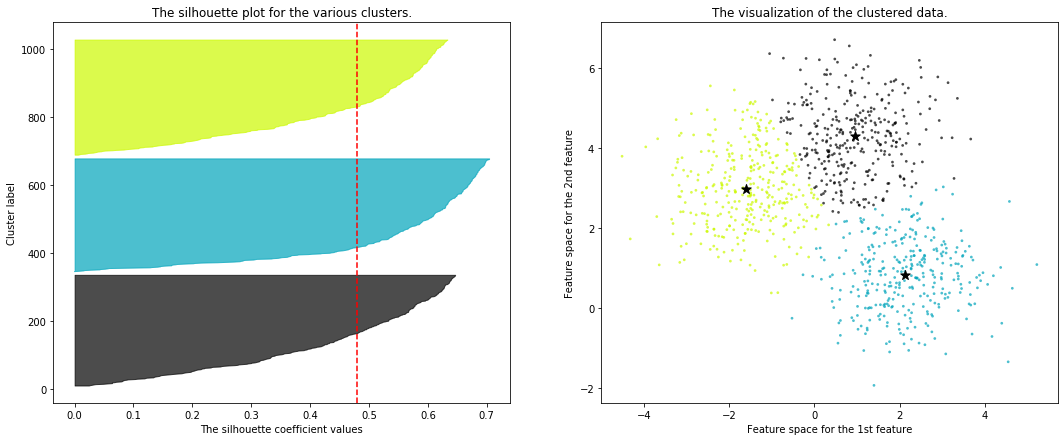

In [11]:
random_state=0
n_clusters = 3

km = KMeans(n_clusters=n_clusters, n_init=10, max_iter=300, tol=1e-04, random_state=random_state)
y_pred = km.fit_predict(x)

silhouette_vals = silhouette_samples(x, y_pred)
clusters_labels = np.unique(y_pred)
nb_clusters = clusters_labels.shape[0]
y_lower = 10

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)


for i in range(nb_clusters):
    cluster_silhouette_vals = silhouette_vals[y_pred == i]
    cluster_silhouette_vals.sort()
    cluster_size = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + cluster_size
    color = cm.nipy_spectral(i / nb_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, facecolor = color, edgecolor=color, alpha = 0.7)
    
    y_lower = y_upper + 10

silhouette_avg = silhouette_score(x, y_pred)
ax1.axvline(x=silhouette_avg, color='red', linestyle='--')
ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")


colors = cm.nipy_spectral(y_pred/ n_clusters)
ax2.scatter(x[:, 0], x[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor=colors)
ax2.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=100, marker='*', c='black')
ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

#plt.suptitle((f'Silhouette analysis for KMeans clustering on sample data with n_clusters = {n_clusters}'), fontsize=14, fontweight='bold')

fig.show()

-----

### 2.2 Adjusted Rand Index (ARI)

Assume, that we know true labels of classes. Let be $n$ the number of objects in the sample. Denote by $a$ the set of pairs that have the same labels and are present in the same cluster and denote by $b$ the set of pairs that have the same labels and are present in different clusters. Thus, RI will be:

$$ RI = \frac{2(a+b)}{n(n-1)}$$

RI shows the proportion of objects for which these partitions (the original and the resulting clustering) are “consistent”. It shows similarity of two clusterings. 

Normalize this score: 
$$ARI = \frac{RI-E[RI]}{max(RI)-E[RI]},$$

where $ARI \in [-1,1]$, if ARI is close to 1, it means that to partitions are very simmilar. 

Use ARI when the ground truth clustering has large equal sized clusters.


```python
sklearn.metrics.adjusted_rand_score
```

----

### 2.3 Adjusted Mutual Information (AMI)

[Mutual information](https://en.wikipedia.org/wiki/Mutual_information) - mutual information measures the proportion of information common to both partitions: how much information about one of them reduces uncertainty about the other. Assume that we have two partitions U and V, then MI will be calculated by the following formula:

$$MI = \sum_{i=1}^{|U|}\sum_{j=1}^{|V|}\frac{|U_i \cap V_j|}{N} \log\frac{|U_i \cap V_j|}{|U_i| |V_j|}$$



Then AMI will be:

$$AMI(U, V) = \frac{MI(U, V) - E[MI(U, V)]}{mean(H(U), H(V)) - E[MI(U, V)]}$$

Use AMI when the ground truth clustering is unbalanced and there exist small clusters

```python
sklearn.metrics.adjusted_mutual_info_score
```
-----

### 2.4 Homogeneity

Let $C$ - true clusters, $K$ - results of clustering, $H()$ - entrop function. Then homogeneity can be define by the following formula:
    
$$h=1 - \frac{H(C|K)}{H(C)}, $$

where $h \in [0,1]$ higher values correspond to more accurate clustering.

Homogeneity measures if each cluster consists of objects of the same class

```python
sklearn.metrics.homogeneity_score
```

----

### 2.5 Completeness

Let $C$ - true clusters, $K$ - results of clustering, $H()$ - entrop function. Then completeness can be define by the following formula:
    
$$c=1-\frac{H(K|C)}{H(K)}, $$
    
where $c \in [0,1]$ higher values correspond to more accurate clustering.

Recall measures how much objects of the same class belong to the same cluster.

```python
sklearn.metrics.completeness_score
```


### 2.6 V-score

Let $C$ - true clusters, $K$ - results of clustering, $H()$ - entrop function, h - homogeneity, c - completeness. Then V-score can be define as harmonic mean of $c$ and $h$:
    
$$V-{score}=2\frac{hc}{h+c}$$

It is symmetric and shows how the two clusters are similar to each other.

```python
sklearn.metrics.metrics.v_measure_score
```

----

### 2.7 Practical example

In [15]:
from sklearn import metrics
from sklearn import datasets
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering

data = datasets.load_digits()
X, y = data.data, data.target

algorithms = []
algorithms.append(KMeans(n_clusters=10, random_state=1))
algorithms.append(AffinityPropagation())
algorithms.append(SpectralClustering(n_clusters=10, random_state=1,
                                     affinity='nearest_neighbors'))
algorithms.append(AgglomerativeClustering(n_clusters=10))

data = []
for algo in algorithms:
    algo.fit(X)
    data.append(({
        'ARI': metrics.adjusted_rand_score(y, algo.labels_),
        'AMI': metrics.adjusted_mutual_info_score(y, algo.labels_),
        'Homogenity': metrics.homogeneity_score(y, algo.labels_),
        'Completeness': metrics.completeness_score(y, algo.labels_),
        'V-measure': metrics.v_measure_score(y, algo.labels_),
        'Silhouette': metrics.silhouette_score(X, algo.labels_)}))

results = pd.DataFrame(data=data, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure', 
                                           'Silhouette'],
                       index=['K-means', 'Affinity', 
                              'Spectral', 'Agglomerative'])

results

,ARI,AMI,Homogenity,Completeness,V-measure,Silhouette
K-means,0.668587,0.741156,0.739464,0.748061,0.743737,0.182524
Affinity,0.175174,0.612460,0.958907,0.486901,0.645857,0.115197
Spectral,0.756461,0.852040,0.831691,0.876614,0.853562,0.182729
Agglomerative,0.794003,0.866832,0.857513,0.879096,0.868170,0.178497
